# Projeto Final - Ciência dos dados
### Alunos:
- Beatriz Lourenço 
- Fernando Kenji 
- Sophia Kerber
- Pedro H. Menezes

### Pergunta Motivadora:
É possível prever a avaliação de um livro (no ranking do Goodreads) com as seguintes variáveis?
- Inicial do autor
- Número de páginas
- Gênero
- Formato do livro (Capa dura, capa em papel, versão Kindle...)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [3]:
# Base de dados original
csv = pd.read_csv('book_data.csv')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [4]:
# Retirando os livros com informações faltando
csv=csv.dropna()
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...


In [5]:
ar = csv['genres'].value_counts()
ar1 = []
iniciais = []
paginas = []

# Escolhendo como gênero literário apenas o primeiro listado.
for i in ar.index:
    if i == "":
        ar1.append("")
    else:
        a = i.split('|')
        ar1.append(a[0])
        
# Selecionando apenas a inicial dos nomes dos autores
for i in csv['book_authors']:
    iniciais.append(i[0])

# Apenas o número de páginas aparecerá, sem a palavra "pages"
for i in csv['book_pages']:
    numero = i.split(' ')
    paginas.append(int(numero[0]))
print(paginas[0:10])
print(iniciais[0:10])
print(ar1[0:10])

[870, 324, 279, 552, 767, 1728, 464, 434, 367, 507]
['J', 'H', 'J', 'M', 'C', 'J', 'E', 'A', 'O', 'C']
['Fantasy', 'Fiction', 'Fantasy', 'Science Fiction', 'Classics', 'Classics', 'Classics', 'Classics', 'Novels', 'Romance']


In [6]:
len(csv.index)

3535

In [7]:
# Criando colunas no DataFrame para as iniciais dos autores, os números de páginas e o principal gênero do livro
ar1=pd.DataFrame({'genero':ar1})
iniciais_ = pd.DataFrame({'iniciais':iniciais})
paginas_ = pd.DataFrame({'paginas':paginas})

In [8]:
csv = csv.join(ar1,how='inner')
csv = csv.join(iniciais_,how='inner')
csv = csv.join(paginas_,how='inner')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,genero,iniciais,paginas
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,Fiction,H,324
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,Fantasy,J,279
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...,Science Fiction,M,552
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...,Classics,J,1728
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...,Classics,E,464


In [9]:
# Retirando as colunas irrelevantes para a análise geral de avaliações
csv.drop(['book_isbn','book_authors','book_desc','book_edition','book_rating_count','book_review_count','genres','image_url','book_pages'],axis=1,inplace=True)

In [10]:
csv.head()

,book_format,book_rating,book_title,genero,iniciais,paginas
1,Paperback,4.48,Harry Potter and the Order of the Phoenix,Fiction,H,324
2,Paperback,4.27,To Kill a Mockingbird,Fantasy,J,279
3,Paperback,4.25,Pride and Prejudice,Science Fiction,M,552
5,Hardcover,4.36,The Book Thief,Classics,J,1728
6,Paperback,4.25,The Chronicles of Narnia,Classics,E,464


In [11]:
csv['genero'].value_counts()

Fiction                71
Fantasy                67
Classics               41
Romance                30
Nonfiction             29
Young Adult            29
Historical             19
Philosophy             14
Poetry                 13
Sequential Art         12
Science Fiction        12
Mystery                12
History                11
Horror                 11
European Literature     8
Paranormal              8
Thriller                7
Short Stories           5
Biography               4
Childrens               4
Religion                3
Christian Fiction       3
Cultural                3
Plays                   2
Science                 2
Lgbt                    2
Computer Science        2
Crime                   1
Christian               1
Language                1
Erotica                 1
Dark                    1
Academic                1
Economics               1
New Adult               1
Roman                   1
Culture                 1
Business                1
Parenting   

In [12]:
csv.shape

(449, 6)

In [13]:
# Apenas os livros com 3.5 estrelas ou mais de avaliação no Goodreads
csv.loc[(csv['book_rating']>= 3.5)]

,book_format,book_rating,book_title,genero,iniciais,paginas
1,Paperback,4.48,Harry Potter and the Order of the Phoenix,Fiction,H,324
2,Paperback,4.27,To Kill a Mockingbird,Fantasy,J,279
3,Paperback,4.25,Pride and Prejudice,Science Fiction,M,552
5,Hardcover,4.36,The Book Thief,Classics,J,1728
6,Paperback,4.25,The Chronicles of Narnia,Classics,E,464
...,...,...,...,...,...,...
2656,Hardcover,3.97,Hades,Business,A,398
2664,Paperback,4.22,Wings of Fire: An Autobiography,Historical,L,248
2666,Paperback,3.97,How Not to Murder Your Grumpy,History,I,1000
2683,Paperback,4.01,The Three Stigmata of Palmer Eldritch,Classics,S,864


In [14]:
# Separando as variáveis em quantitativas, qualitativas e a desejada
y = csv['book_rating'].values
num = csv[['paginas']]
qual = csv[['book_format','genero','iniciais']]

In [15]:
qual.head()

,book_format,genero,iniciais
1,Paperback,Fiction,H
2,Paperback,Fantasy,J
3,Paperback,Science Fiction,M
5,Hardcover,Classics,J
6,Paperback,Classics,E


In [16]:
encoder = OneHotEncoder()
capa_encoded = encoder.fit_transform(qual)

In [17]:
x_num = num.values

In [26]:
#Transformar em array facilita a exploração dos dados
x_encoded = capa_encoded.toarray()

In [27]:
#Juntando a lista binária e as páginas
X = np.concatenate((x_num,x_encoded), axis=1)

In [20]:
X[0]

array([324.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [28]:
#Rating do livro 1
y[0]

4.48

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing,utils, metrics
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i]>5:
        y_pred[i]=5
    elif y_pred[i]<0:
        y_pred[i]=0
        
df = pd.DataFrame({'Atual': y_test.flatten(), 'Predito': y_pred.flatten()})
df.head()

,Atual,Predito
0,4.10,4.009544
1,4.27,4.028935
2,3.57,3.880674
3,4.24,4.200379
4,4.09,3.998281


In [45]:
#Usando outro DataFrame (de 2018) para fazer a predição:
teste_X = pd.read_csv('book_data_2018.csv')
teste_X.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Kristin Hannah,"Alaska, 1974.Unpredictable. Unforgiving. Untam...",NaN,Kindle Edition,NaN,435 pages,4.33,146505,17438,The Great Alone,Fiction|Historical|Historical Fiction|Audioboo...,https://images.gr-assets.com/books/1501852423l...
1,Madeline Miller,"In the house of Helios, god of the sun and mig...",NaN,Hardcover,9.780000e+12,393 pages,4.34,61357,9369,Circe,Fantasy|Fiction|Fantasy|Mythology|Historical|H...,https://images.gr-assets.com/books/1508879575l...
2,Holly Black,Of course I want to be like them. They’re beau...,NaN,Hardcover,9.780000e+12,370 pages,4.18,62897,11948,The Cruel Prince,Fantasy|Young Adult|Fairies|Fae,https://images.gr-assets.com/books/1493047153l...
3,A.J. Finn,Anna Fox lives alone—a recluse in her New York...,NaN,Kindle Edition,NaN,449 pages,3.97,175678,20645,The Woman in the Window,Mystery|Thriller|Fiction|Suspense|Thriller|Mys...,https://images.gr-assets.com/books/1528225499l...
4,Tara Westover,An unforgettable memoir in the tradition of Th...,NaN,Hardcover,9.780000e+12,334 pages,4.47,128337,16424,Educated,Nonfiction|Autobiography|Memoir|Biography,https://images.gr-assets.com/books/1506026635l...


In [49]:
teste_X=teste_X.dropna()
teste_X.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
35,Jordan B. Peterson|Norman Doidge|Ethan Van Sciver,What does everyone in the modern world need to...,Canadian First Edition,Hardcover,9.780000e+12,448 pages,4.01,34183,3653,12 Rules for Life: An Antidote to Chaos,Nonfiction|Psychology|Philosophy|Self Help|Sel...,https://images.gr-assets.com/books/1512705866l...
44,Audrey Grey|Krystal Wade,"While she sleeps, the whole universe changes.P...",1st Edition,Paperback,9.780000e+12,316 pages,3.78,347,182,Our Dark Stars,Science Fiction|Young Adult|Romance|Fantasy,https://images.gr-assets.com/books/1513086665l...
46,Jewel E. Ann,Flint Hopkins finds the perfect tenant to rent...,1 edition,Paperback,9.780000e+12,380 pages,4.28,9785,1256,Look the Part,Romance|Contemporary|Romance|Contemporary Roma...,https://images.gr-assets.com/books/1513599758l...
62,L.J. Shen,"From bestselling author L.J. Shen, comes a new...",1st Edition,Paperback,9.780000e+12,328 pages,4.27,10989,1607,Dirty Headlines,Romance|Romance|Contemporary Romance|Contemporary,https://images.gr-assets.com/books/1534425084l...
76,Laura Thalassa,"They came to earth—Pestilence, War, Famine, De...",2nd Edition,Paperback,9.780000e+12,381 pages,4.06,13671,1886,Pestilence,Romance|Fantasy|New Adult|Fantasy|Paranormal|R...,https://images.gr-assets.com/books/1537316666l...


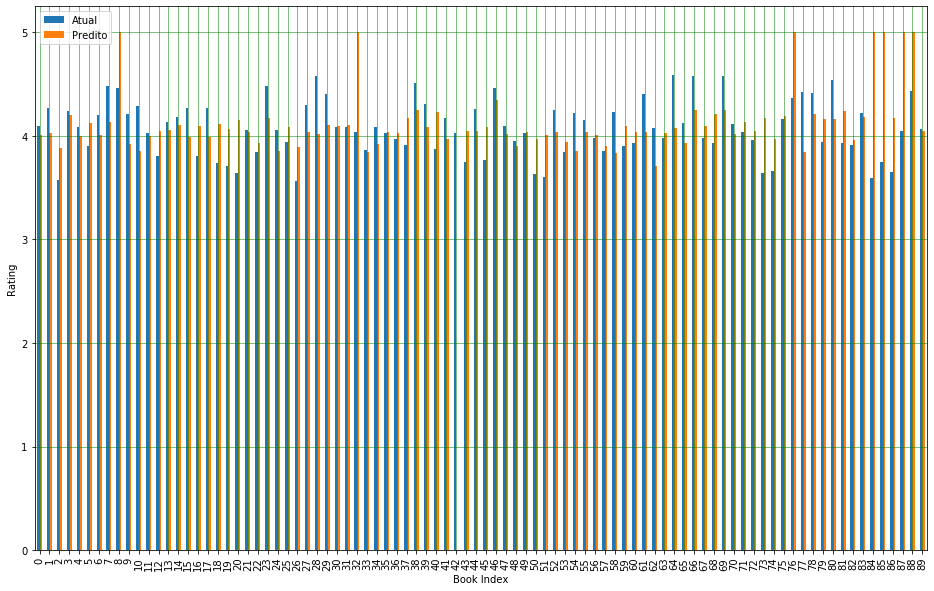

In [23]:
df1 = df
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Book Index')
plt.ylabel('Rating')
plt.show()

In [24]:
print("O R² é " + str(metrics.r2_score(df['Atual'],df['Predito'])))

O R² é -3.470841730924935
